In [96]:
# Libraries imported
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [71]:
# Loading the sample dataset
df = pd.read_csv('/Users/salnaqeeb/Downloads/bq-results-20230321-215404-1679435672783.csv')

In [72]:
# Removing unneccessary columns after determining what we need.
df = df.drop(columns=['timestamp',
                      'tiemstamp_AEST',
                      'enhanced_altitude',
                      'ascent',
                      'grade',
                      'calories',
                      'enhanced_speed',
                      'heart_rate',
                      'temperature',
                      'cadence',
                      'power',
                      'gps_accuracy',
                      'sessionID',
                      'age',
                      'gender',
                      'weight',
                      'FTP'
                      ])

In [73]:
df.head()

,date_AEST,distance,userID
0,2022-10-31,17.73928,U1000000
1,2022-11-04,0.03105,U1000000
2,2022-11-05,13.12674,U1000000
3,2022-11-05,47.57553,U1000000
4,2022-11-05,90.03022,U1000000


In [74]:
# Create a new DataFrame with additional users and rides
new_data = pd.DataFrame({
    'userID': ['U1000001', 'U1000001', 'U1000001', 'U1000001', 'U1000002', 'U1000002', 'U1000002', 'U1000002',
               'U1000003', 'U1000003', 'U1000003', 'U1000003'],
    'date_AEST': ['2022-11-05', '2022-11-07', '2022-11-09', '2022-11-12',
                  '2022-11-06', '2022-11-08', '2022-11-10', '2022-11-13',
                  '2022-11-05', '2022-11-08', '2022-11-10', '2022-11-11'],
    'distance': [12.5, 10.3, 8.7, 11.2, 9.1, 7.4, 6.8, 8.5, 15.2, 14.3, 13.7, 12.8]
})

# Concatenate the new data with the original dataset
df = pd.concat([df, new_data], ignore_index=True)

# Display the updated dataset
print(df)

          date_AEST  distance    userID
0        2022-10-31  17.73928  U1000000
1        2022-11-04   0.03105  U1000000
2        2022-11-05  13.12674  U1000000
3        2022-11-05  47.57553  U1000000
4        2022-11-05  90.03022  U1000000
...             ...       ...       ...
1544679  2022-11-13   8.50000  U1000002
1544680  2022-11-05  15.20000  U1000003
1544681  2022-11-08  14.30000  U1000003
1544682  2022-11-10  13.70000  U1000003
1544683  2022-11-11  12.80000  U1000003

[1544684 rows x 3 columns]


## Only 4 rows taken of the original dataset for one user, and added 3 other users so that it becomes easier to test.

In [75]:
# Filter the dataset to keep only the first 4 rows for each user
df = df.groupby('userID').head(4)

# Display the updated dataset
print(df)

          date_AEST  distance    userID
0        2022-10-31  17.73928  U1000000
1        2022-11-04   0.03105  U1000000
2        2022-11-05  13.12674  U1000000
3        2022-11-05  47.57553  U1000000
1544672  2022-11-05  12.50000  U1000001
1544673  2022-11-07  10.30000  U1000001
1544674  2022-11-09   8.70000  U1000001
1544675  2022-11-12  11.20000  U1000001
1544676  2022-11-06   9.10000  U1000002
1544677  2022-11-08   7.40000  U1000002
1544678  2022-11-10   6.80000  U1000002
1544679  2022-11-13   8.50000  U1000002
1544680  2022-11-05  15.20000  U1000003
1544681  2022-11-08  14.30000  U1000003
1544682  2022-11-10  13.70000  U1000003
1544683  2022-11-11  12.80000  U1000003


In [85]:
# Convert the 'date_AEST' column to a datetime format
df['date_AEST'] = pd.to_datetime(df['date_AEST'])

# Sort the data by user and date in ascending order
df.sort_values(['userID', 'date_AEST'], inplace=True)

# Create a new DataFrame to store the engagement scores
engagement_scores = pd.DataFrame(columns=['userID', 'engagement_score'])

# Calculate the engagement scores for each user
for user in df['userID'].unique():
    user_data = df[df['userID'] == user]  # Filter data for the current user
    score = 0  # Initialize the score for the current user

    # Each ride = +1 point
    score += user_data.shape[0]

    # Riding more than once per day = +1 point
    rides_per_day = user_data.groupby(user_data['date_AEST'].dt.date)['distance'].count()
    score += (rides_per_day > 1).sum()

    # Riding in consecutive days = +2 points
    consecutive_days = user_data['date_AEST'].diff().dt.days == 1
    score += consecutive_days.sum() * 2
    
    # Most rides in a week = +2 point
    max_rides_in_week = user_data.groupby(user_data['date_AEST'].dt.week)['distance'].count().max()
    score += (user_data.groupby(user_data['date_AEST'].dt.week)['distance'].count() == max_rides_in_week).sum() * 2

    # Riding after being inactive for 7 days = +5 points
    inactive_days = (user_data['date_AEST'].diff().dt.days >= 7).cumsum()
    score += (inactive_days > 0).sum() * 5

    # Not riding for three consecutive days = -1 point
    # not_riding = (user_data['date_AEST'].diff().dt.days >= 3).cumsum()
    # score -= (not_riding > 0).sum()

    # Append the user's engagement score to the DataFrame
    engagement_scores = engagement_scores.append({'userID': user, 'engagement_score': score}, ignore_index=True)

# Display the engagement scores
print(engagement_scores)

     userID engagement_score
0  U1000000                9
1  U1000001                6
2  U1000002                6
3  U1000003                8


/var/folders/pb/m60063kx4bj2x6xcwm1ntqkc0000gn/T/ipykernel_30195/2445266269.py:27: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  max_rides_in_week = user_data.groupby(user_data['date_AEST'].dt.week)['distance'].count().max()
/var/folders/pb/m60063kx4bj2x6xcwm1ntqkc0000gn/T/ipykernel_30195/2445266269.py:28: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  score += (user_data.groupby(user_data['date_AEST'].dt.week)['distance'].count() == max_rides_in_week).sum() * 2
/var/folders/pb/m60063kx4bj2x6xcwm1ntqkc0000gn/T/ipykernel_30195/2445266269.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  engagement_scores = engagement_scores.append({'userID': user, 'engagement_score': score}, ignore_index=True)
/var/folders/pb/m60063kx4bj2x6xcwm1ntqkc000

In [86]:
# Rank the users based on their engagement scores
ranked_users = engagement_scores.sort_values(by='engagement_score', ascending=False)

# Display the ranked users with their points
for rank, (user, score) in enumerate(zip(ranked_users['userID'], ranked_users['engagement_score']), start=1):
    print(f"Rank {rank}: User {user}, Points: {score}")


Rank 1: User U1000000, Points: 9
Rank 2: User U1000003, Points: 8
Rank 3: User U1000001, Points: 6
Rank 4: User U1000002, Points: 6


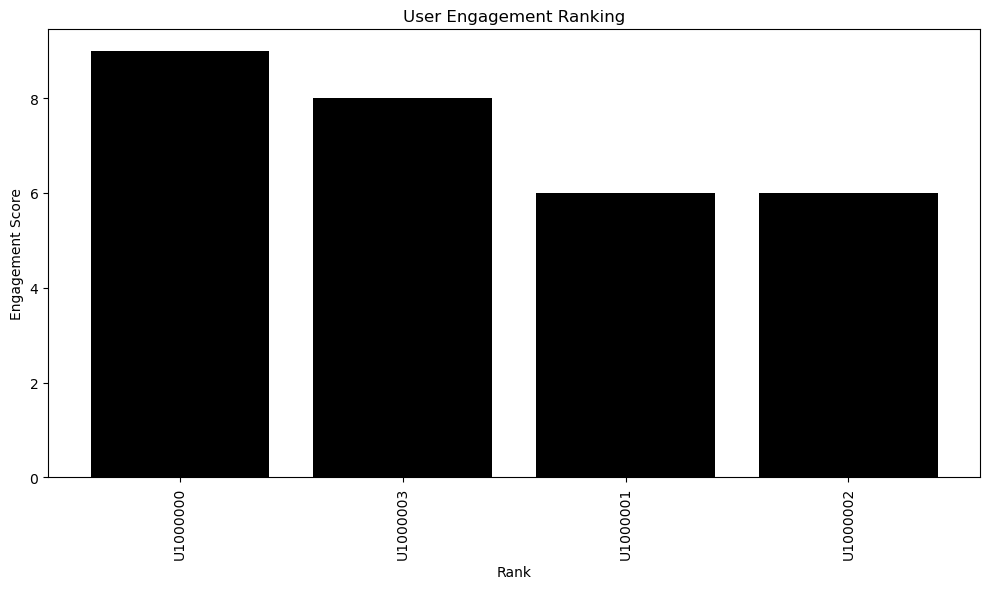

In [89]:
# Plot the ranking
plt.figure(figsize=(10, 6))
plt.bar(range(len(ranked_users)), ranked_users['engagement_score'], color='black')
plt.xlabel('Rank')
plt.ylabel('Engagement Score')
plt.title('User Engagement Ranking')
plt.xticks(range(len(ranked_users)), ranked_users['userID'], rotation='vertical')
plt.tight_layout()
plt.show()

In [88]:
# Create a DataFrame for the ranking
ranking_table = pd.DataFrame({'Rank': range(1, len(ranked_users)+1),
                              'User ID': ranked_users['userID'],
                              'Engagement Score': ranked_users['engagement_score']})

# Display the ranking table
print(ranking_table)

   Rank   User ID Engagement Score
0     1  U1000000                9
3     2  U1000003                8
1     3  U1000001                6
2     4  U1000002                6


## The next part involves only analysis of data after users are ranked

### Segmentation

In [94]:
# Define engagement score thresholds for segmentation
high_threshold = 10
medium_threshold = 5

# Assign segments based on engagement scores
df['Segment'] = pd.cut(ranked_users['engagement_score'], bins=[-float('inf'), medium_threshold, high_threshold, float('inf')],
                       labels=['Low Engagers', 'Medium Engagers', 'High Engagers'])

In [95]:
segment_analysis = df.groupby('Segment').agg({'distance': 'mean', 'userID': 'count'}).rename(columns={'userID': 'User Count'})

print(segment_analysis)

                 distance  User Count
Segment                              
Low Engagers          NaN           0
Medium Engagers  19.61815           4
High Engagers         NaN           0


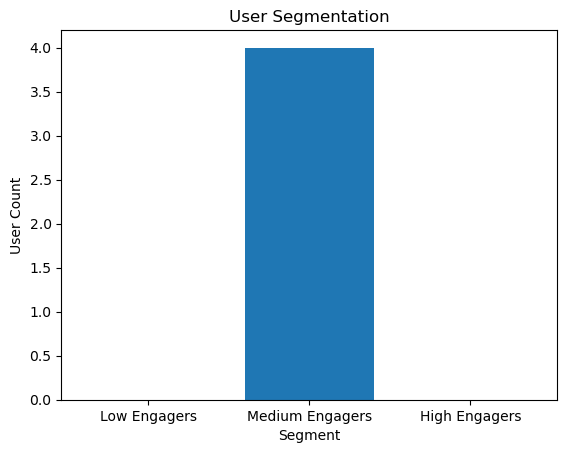

In [97]:
plt.bar(segment_analysis.index, segment_analysis['User Count'])
plt.xlabel('Segment')
plt.ylabel('User Count')
plt.title('User Segmentation')
plt.show()

### Churn Analysis

In [105]:
churn_threshold = 7  # Define the engagement score threshold for churn

churned_users = ranked_users[ranked_users['engagement_score'] < churn_threshold]

average_score = churned_users['engagement_score'].mean()

print("Average Engagement Score for Churned Users: ", average_score)

Average Engagement Score for Churned Users:  6.0


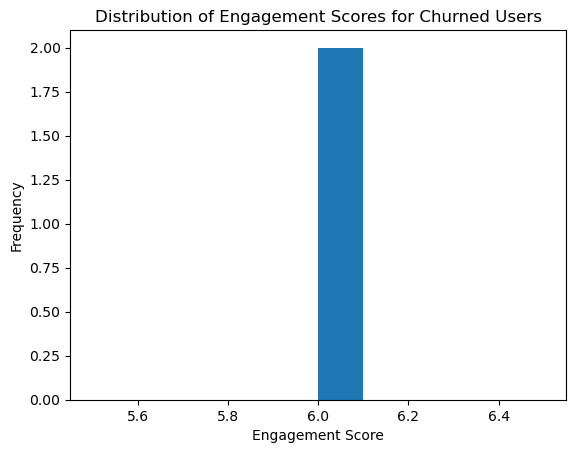

In [106]:
plt.hist(churned_users['engagement_score'], bins=10)
plt.xlabel('Engagement Score')
plt.ylabel('Frequency')
plt.title('Distribution of Engagement Scores for Churned Users')
plt.show()